In [1]:
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from lifelines import CoxPHFitter

In [2]:
pd.set_option('display.max_columns', 30)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.autolayout"] = "true"

%config InlineBackend.figure_format = "retina"

In [3]:
exercicio = pd.read_excel("../data/exercício_analista de dados e gestao.xlsx")

In [4]:
exercicio.head()

,nome completo,data de admissão,data de nascimento,cargo,data de desligamento,etnia,genero
0,pessoa 168,2017-06-26,1979-10-11,ANALISTA I,2018-09-06,Branca,female
1,pessoa 123,2018-04-27,1985-03-17,ANALISTA II,2018-12-21,Branca,female
2,pessoa 185,2018-10-18,1985-05-29,GERENTE,NaT,Branca,female
3,pessoa 91,2017-06-05,1988-07-28,COORDENADOR(A),2020-03-31,Branca,male
4,pessoa 165,2017-01-09,1985-01-04,GERENTE,2019-06-28,Branca,female


In [5]:
data_analise = pd.to_datetime("2022-10-01")

In [6]:
exercicio["idade_na_admissao"] = ((exercicio["data de admissão"] - exercicio["data de nascimento"]) / np.timedelta64(1, "Y")).astype(int)
exercicio["desligado"] = exercicio["data de desligamento"].notna().astype(int)
exercicio["periodo_na_empresa"] = ((exercicio["data de desligamento"].fillna(data_analise) - exercicio["data de admissão"]) / np.timedelta64(1, "M"))

In [7]:
exercicio = exercicio.loc[:, ["cargo", "etnia", "genero", "idade_na_admissao", "desligado", "periodo_na_empresa"]]

In [8]:
exercicio.head()

,cargo,etnia,genero,idade_na_admissao,desligado,periodo_na_empresa
0,ANALISTA I,Branca,female,37,1,14.357584
1,ANALISTA II,Branca,female,33,1,7.819462
2,GERENTE,Branca,female,33,0,47.442453
3,COORDENADOR(A),Branca,male,28,1,33.840531
4,GERENTE,Branca,female,32,1,29.569396


## Exploração de Dados

### Uniariada

In [9]:
def plot_bar(data, x=None, y=None, orient="h", highlight=None, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    df = data[x].value_counts(normalize=True).reset_index().rename(columns={x: "prop", "index": x})
    
    if highlight:
        clrs = ["#63a3c9" if (x != highlight) else "#921a33" for x in df[x]]
    else:
        clrs = ["#63a3c9" for x in df[x]]
    sns.barplot(x=x, y=y if y else "prop", data=data if y else df, palette=clrs, ax=ax)
    return ax

<AxesSubplot: xlabel='genero', ylabel='prop'>

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


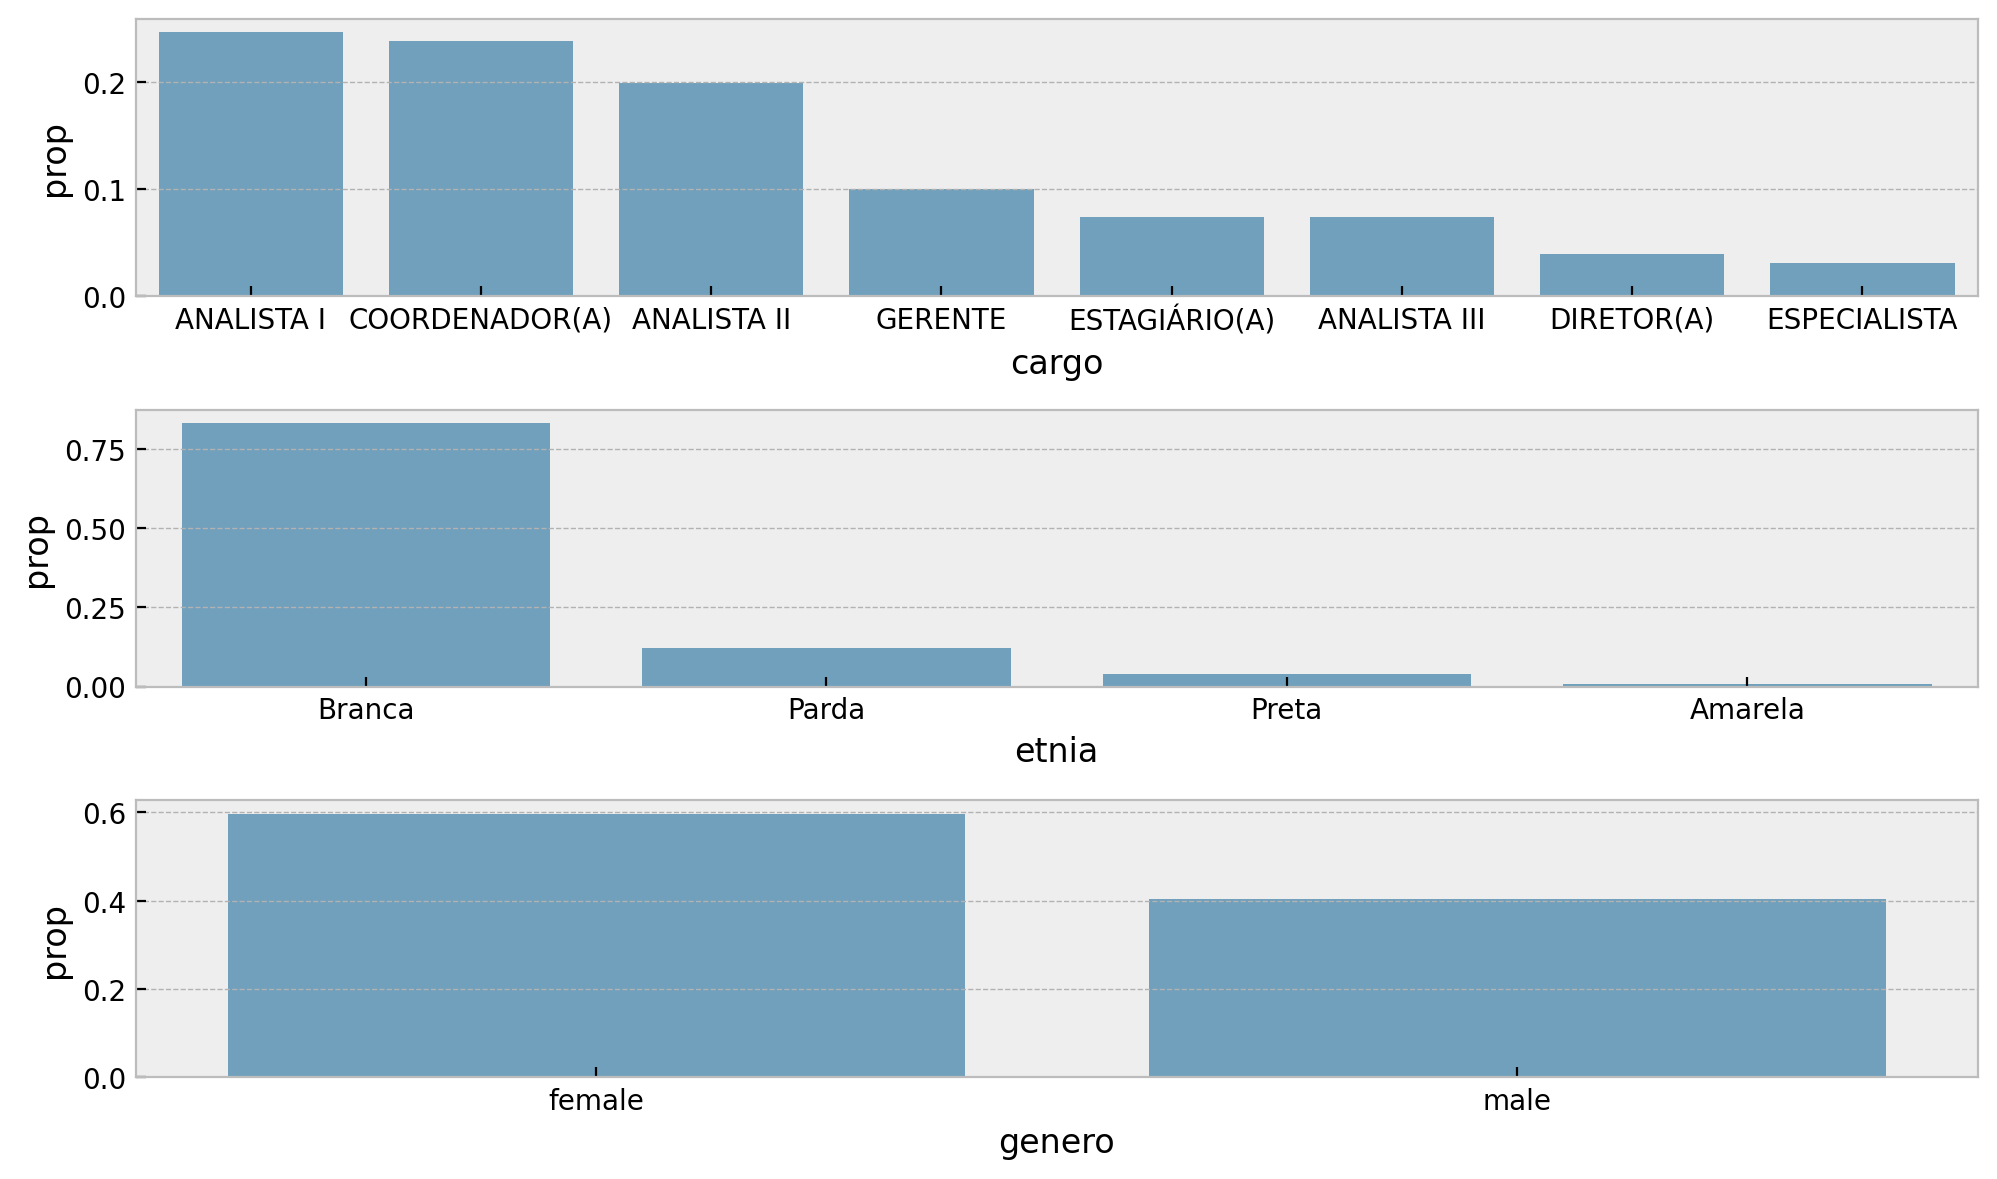

In [10]:
fig, ax = plt.subplots(nrows=3)

plot_bar(x="cargo", data=exercicio, ax=ax[0])
plot_bar(x="etnia", data=exercicio, ax=ax[1])
plot_bar(x="genero", data=exercicio, ax=ax[2])

<AxesSubplot: xlabel='desligado', ylabel='prop'>

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


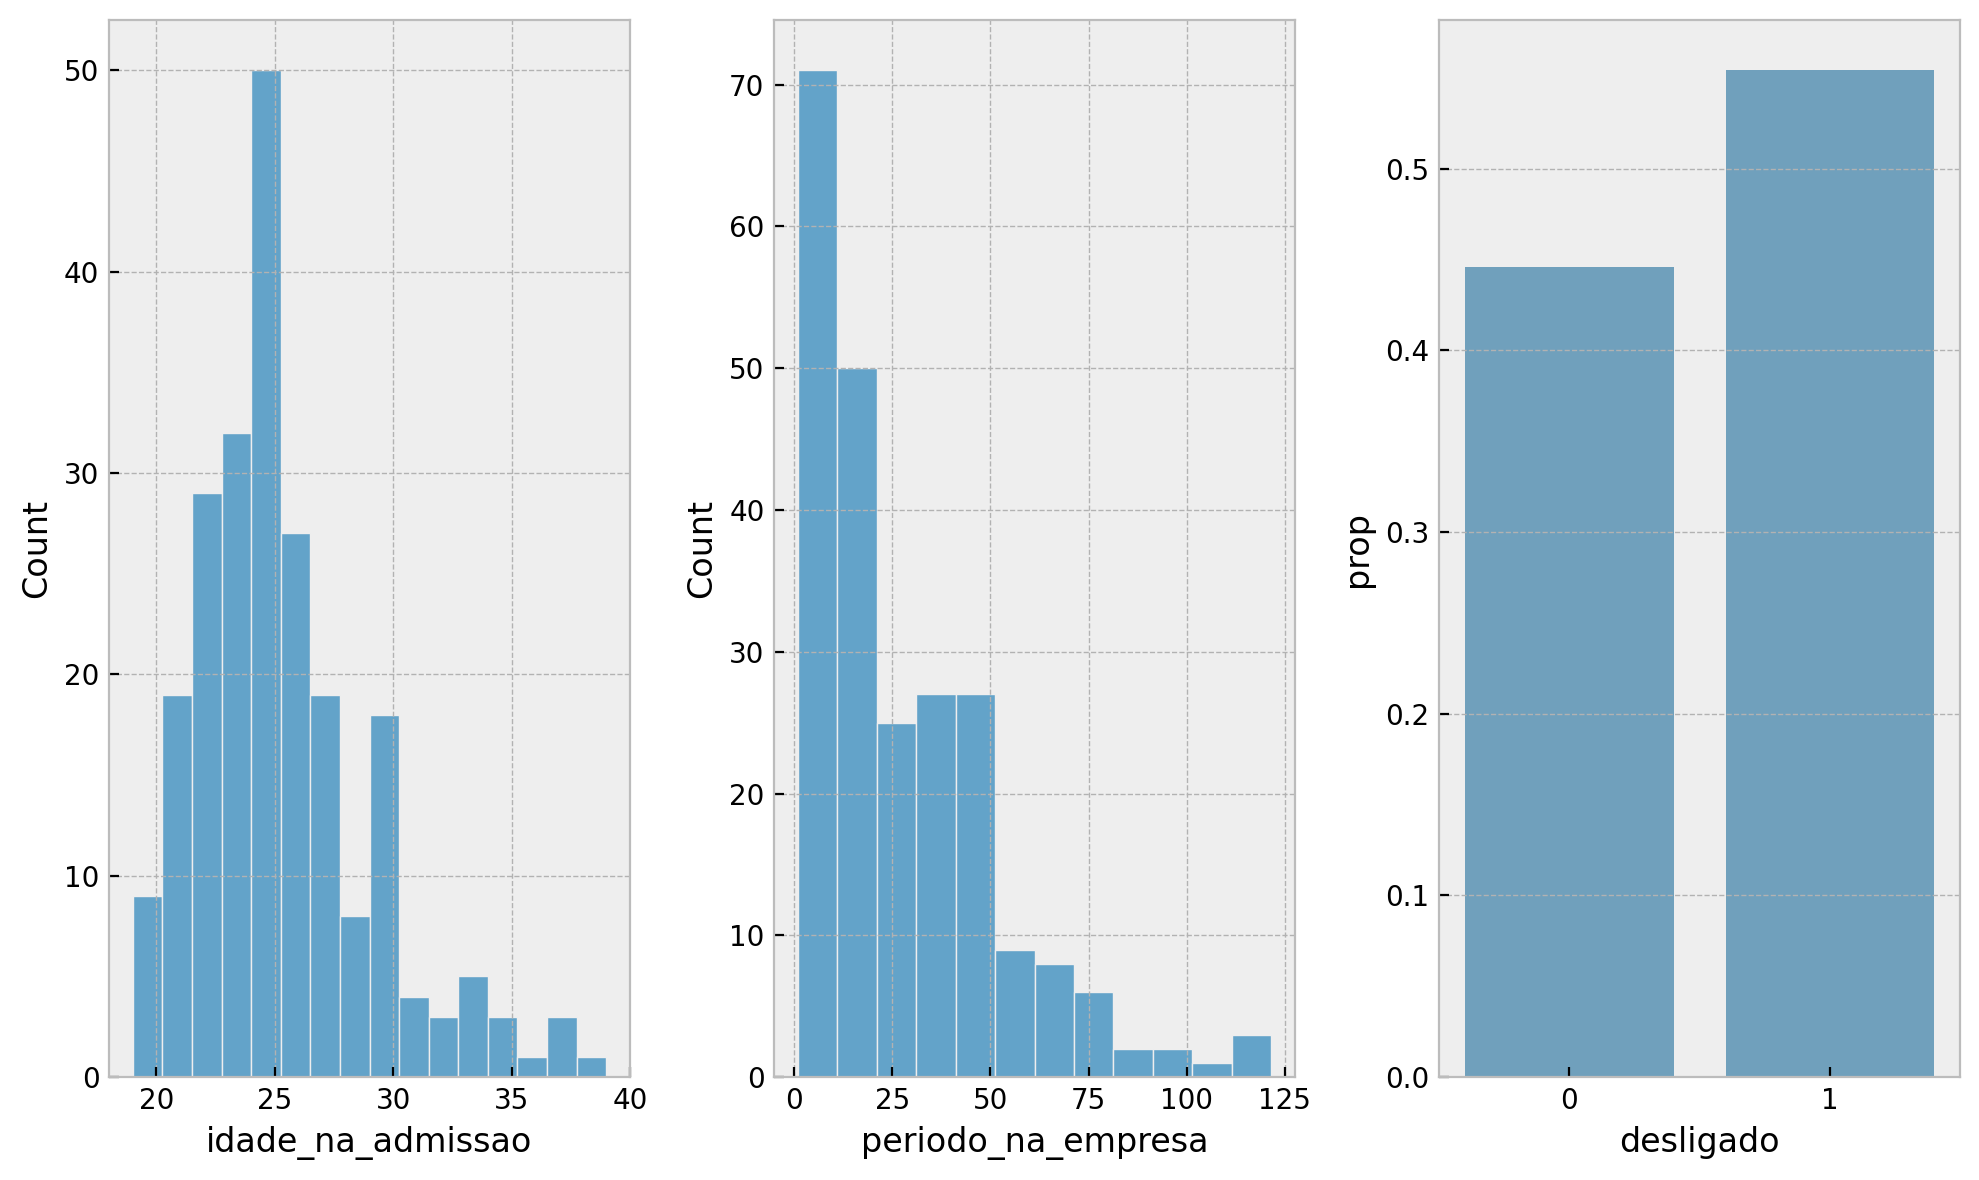

In [11]:
fig, ax = plt.subplots(ncols=3)

sns.histplot(x="idade_na_admissao", data=exercicio, ax=ax[0])
sns.histplot(x="periodo_na_empresa", data=exercicio, ax=ax[1])
plot_bar(x="desligado", data=exercicio, ax=ax[2])

### Bivariada

<AxesSubplot: xlabel='genero', ylabel='desligado'>

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


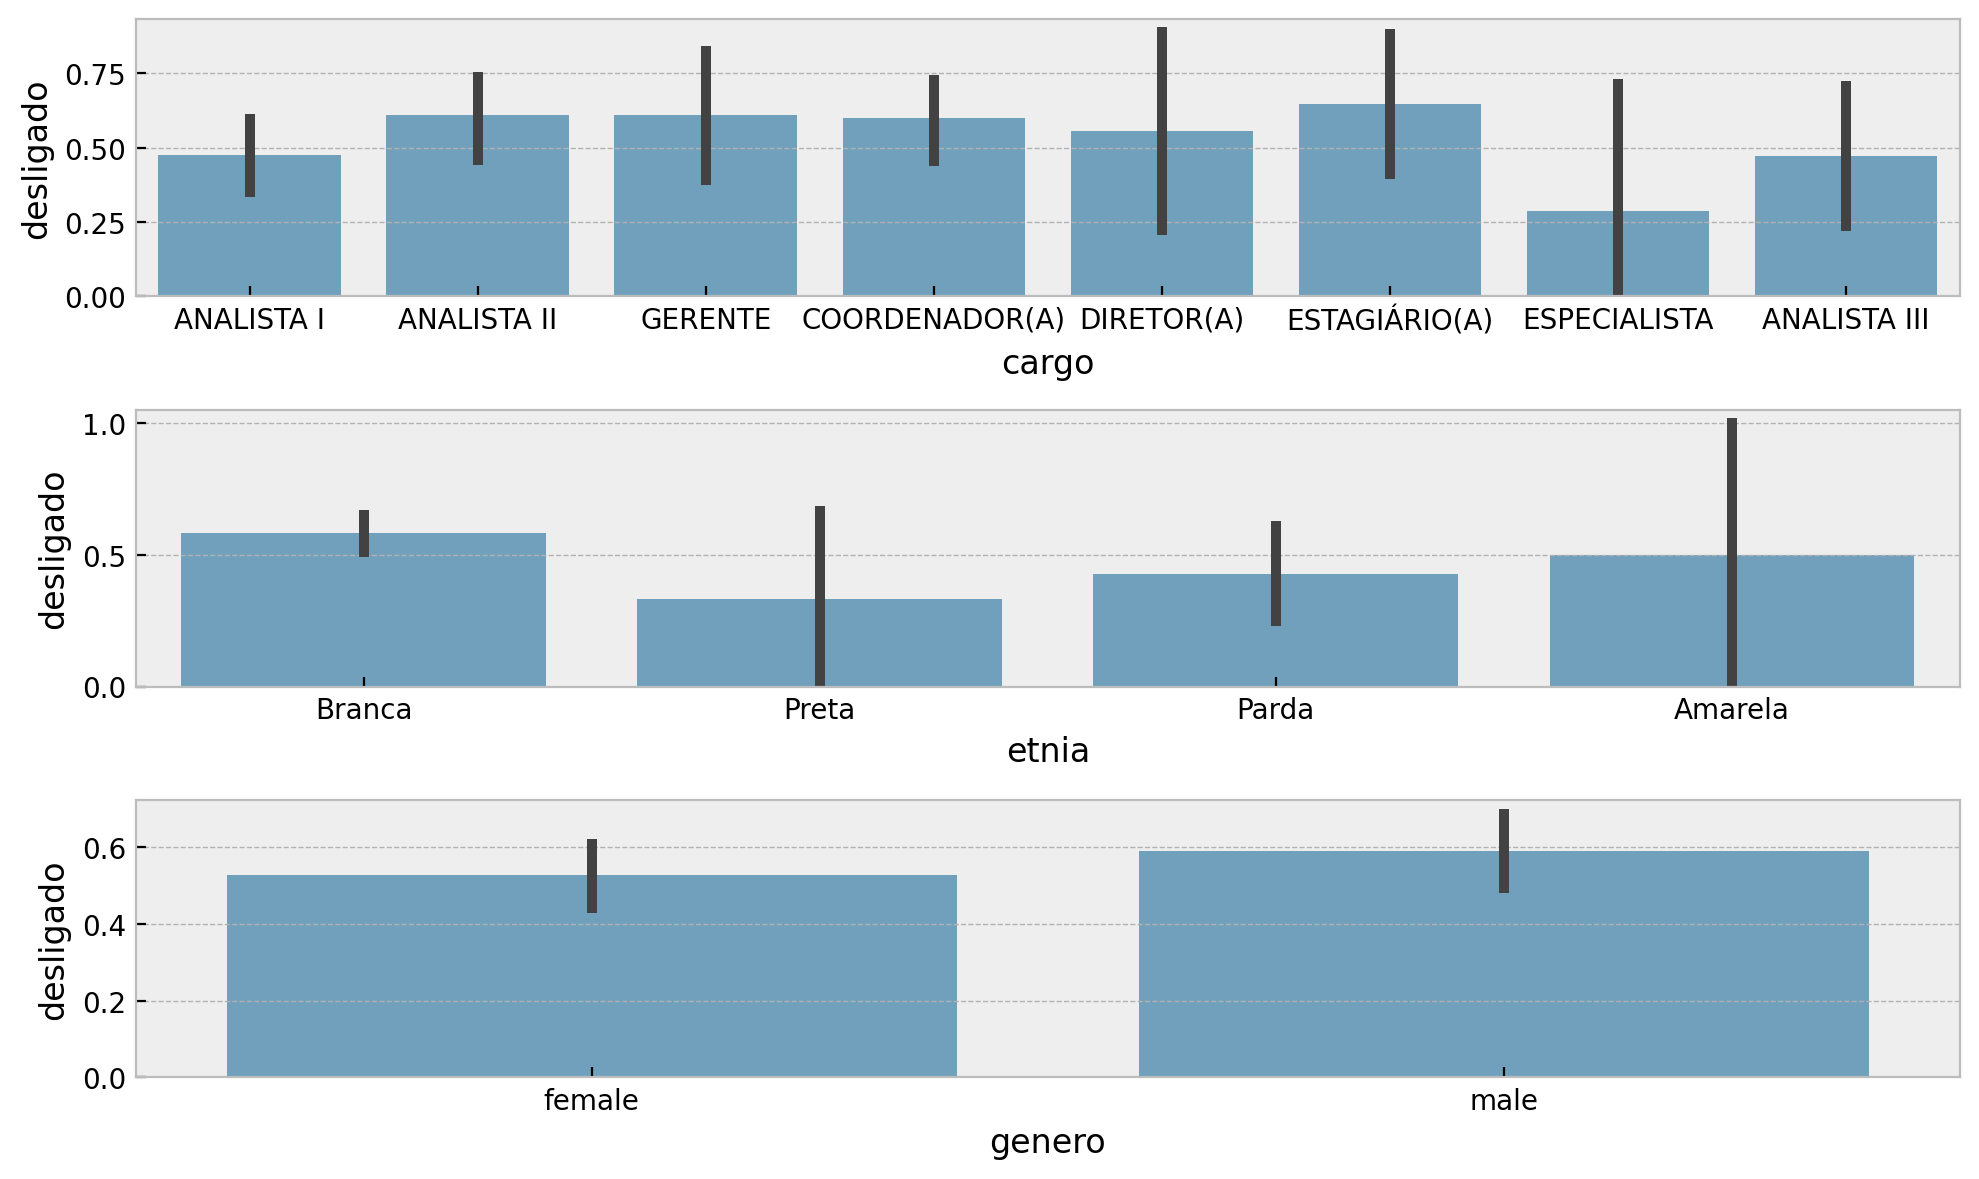

In [12]:
fig, ax = plt.subplots(nrows=3)

plot_bar(x="cargo", y="desligado", data=exercicio, ax=ax[0])
plot_bar(x="etnia", y="desligado", data=exercicio, ax=ax[1])
plot_bar(x="genero", y="desligado", data=exercicio, ax=ax[2])

<AxesSubplot: xlabel='desligado', ylabel='periodo_na_empresa'>

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


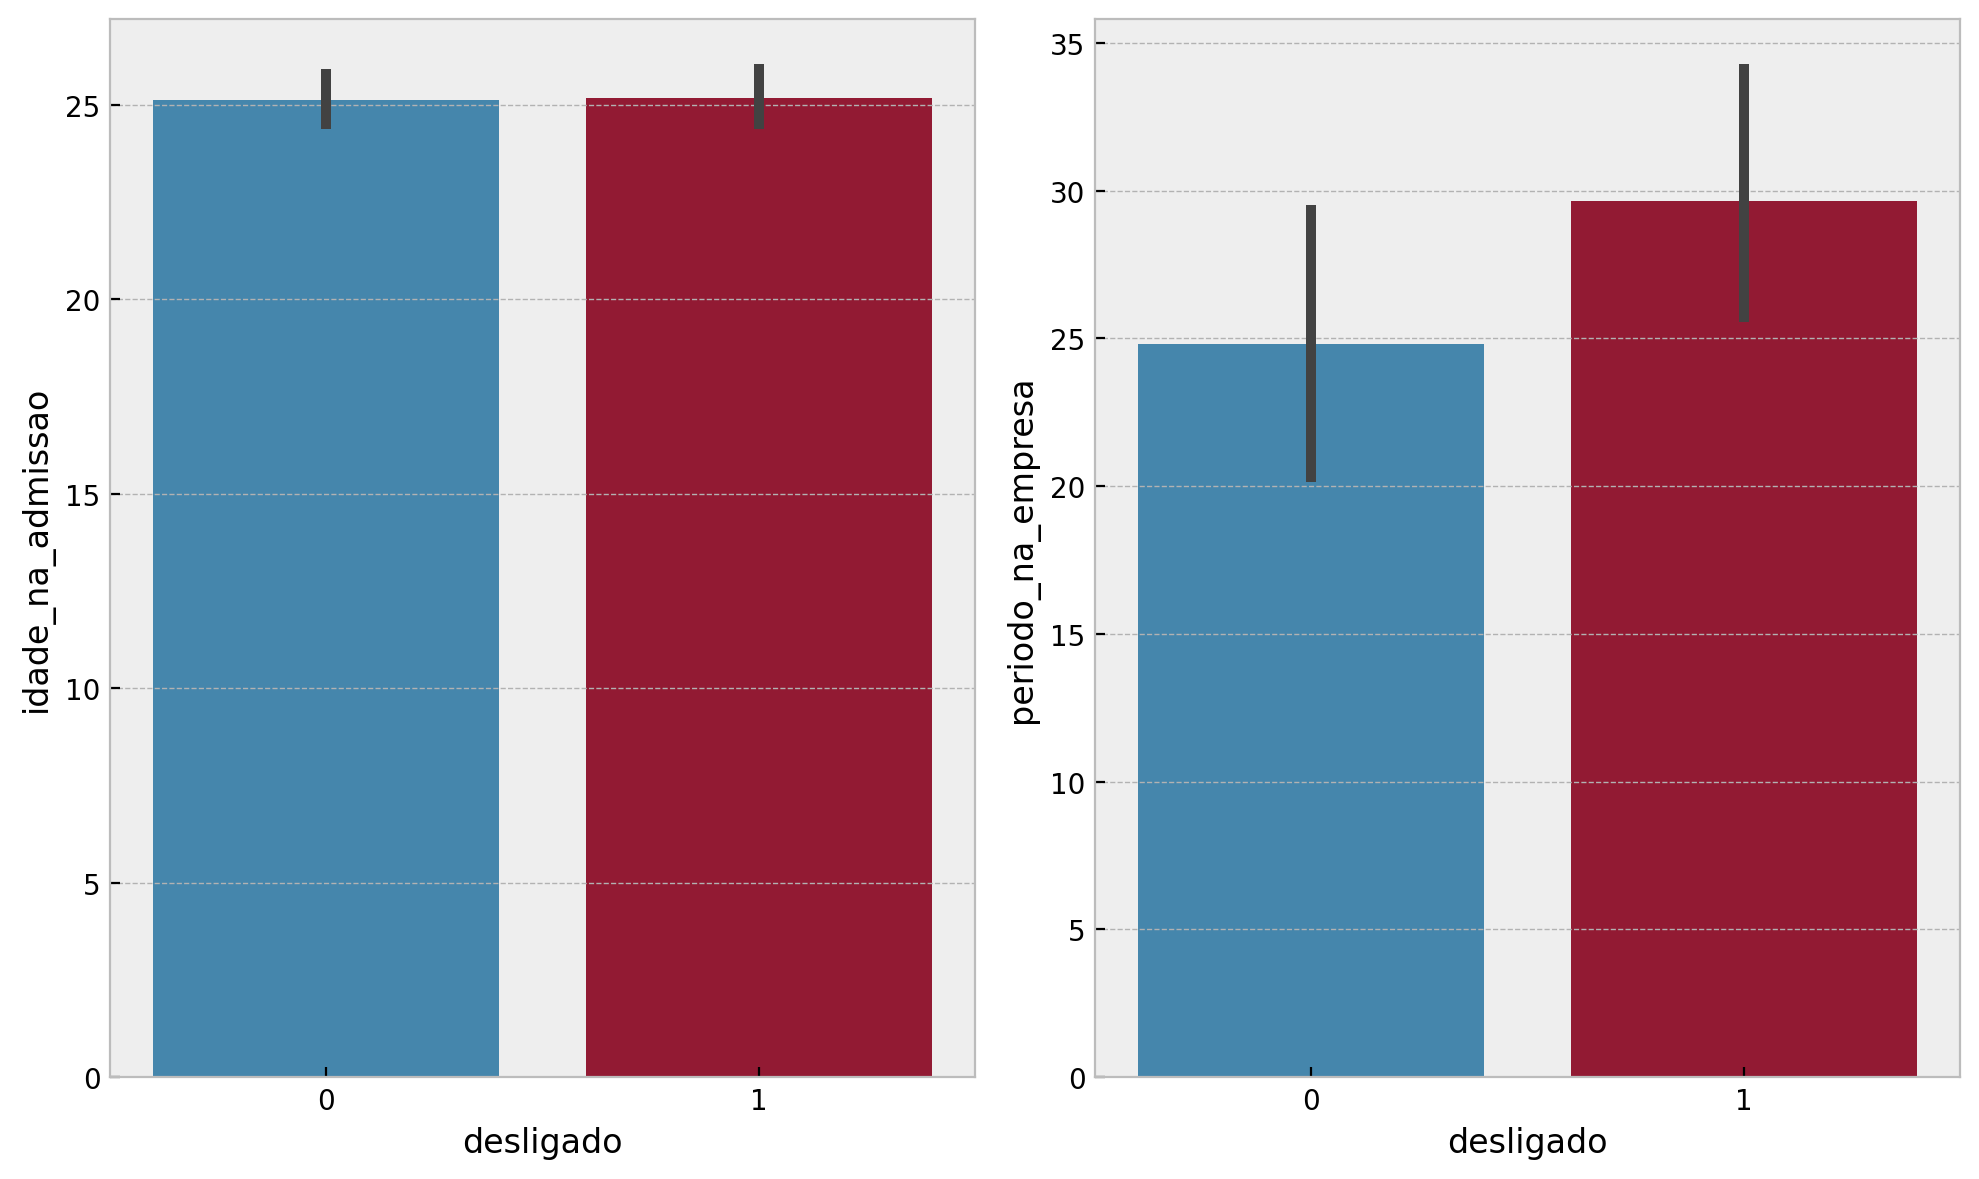

In [13]:
fig, ax = plt.subplots(ncols=2)

sns.barplot(x="desligado", y="idade_na_admissao", data=exercicio, ax=ax[0])
sns.barplot(x="desligado", y="periodo_na_empresa", data=exercicio, ax=ax[1])

## Modelagem

In [14]:
exercicio["cargo"] = pd.Categorical(exercicio["cargo"], categories=['ESTAGIÁRIO(A)', 'ANALISTA I', 'ANALISTA II', 'GERENTE', 'COORDENADOR(A)', 'DIRETOR(A)', 'ESPECIALISTA', 'ANALISTA III'])
exercicio["etnia"] = pd.Categorical(exercicio["etnia"])
exercicio["genero"] = pd.Categorical(exercicio["genero"], categories=["male", "female"])

In [15]:
turnover_analysis = CoxPHFitter()
turnover_analysis.fit(exercicio, duration_col="periodo_na_empresa", event_col="desligado", formula="cargo + etnia + genero + idade_na_admissao")

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


<lifelines.CoxPHFitter: fitted with 231 total observations, 103 right-censored observations>

In [16]:
turnover_analysis.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
cargo[T.ANALISTA I],-1.292014,0.274717,0.407130,-2.089973,-0.494054,0.123690,0.610148,0.0,-3.173468,1.506293e-03,9.374782
cargo[T.ANALISTA II],-1.302455,0.271864,0.385869,-2.058743,-0.546166,0.127614,0.579166,0.0,-3.375383,7.371295e-04,10.405794
cargo[T.GERENTE],-3.230023,0.039557,0.468886,-4.149023,-2.311022,0.015780,0.099160,0.0,-6.888712,5.629998e-12,37.370003
cargo[T.COORDENADOR(A)],-2.705530,0.066835,0.408499,-3.506173,-1.904887,0.030012,0.148839,0.0,-6.623105,3.517307e-11,34.726738
cargo[T.DIRETOR(A)],-4.460535,0.011556,0.643223,-5.721228,-3.199841,0.003276,0.040769,0.0,-6.934666,4.071815e-12,37.837465
cargo[T.ESPECIALISTA],-2.615489,0.073132,0.806725,-4.196641,-1.034338,0.015046,0.355462,0.0,-3.242109,1.186488e-03,9.719087
cargo[T.ANALISTA III],-2.480249,0.083722,0.507455,-3.474842,-1.485656,0.030967,0.226354,0.0,-4.887625,1.020598e-06,19.902154
etnia[T.Branca],0.631682,1.880771,1.025076,-1.377431,2.640795,0.252226,14.024342,0.0,0.616229,5.377433e-01,0.895010
etnia[T.Parda],0.309839,1.363206,1.069549,-1.786439,2.406117,0.167556,11.090811,0.0,0.289691,7.720524e-01,0.373229


C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


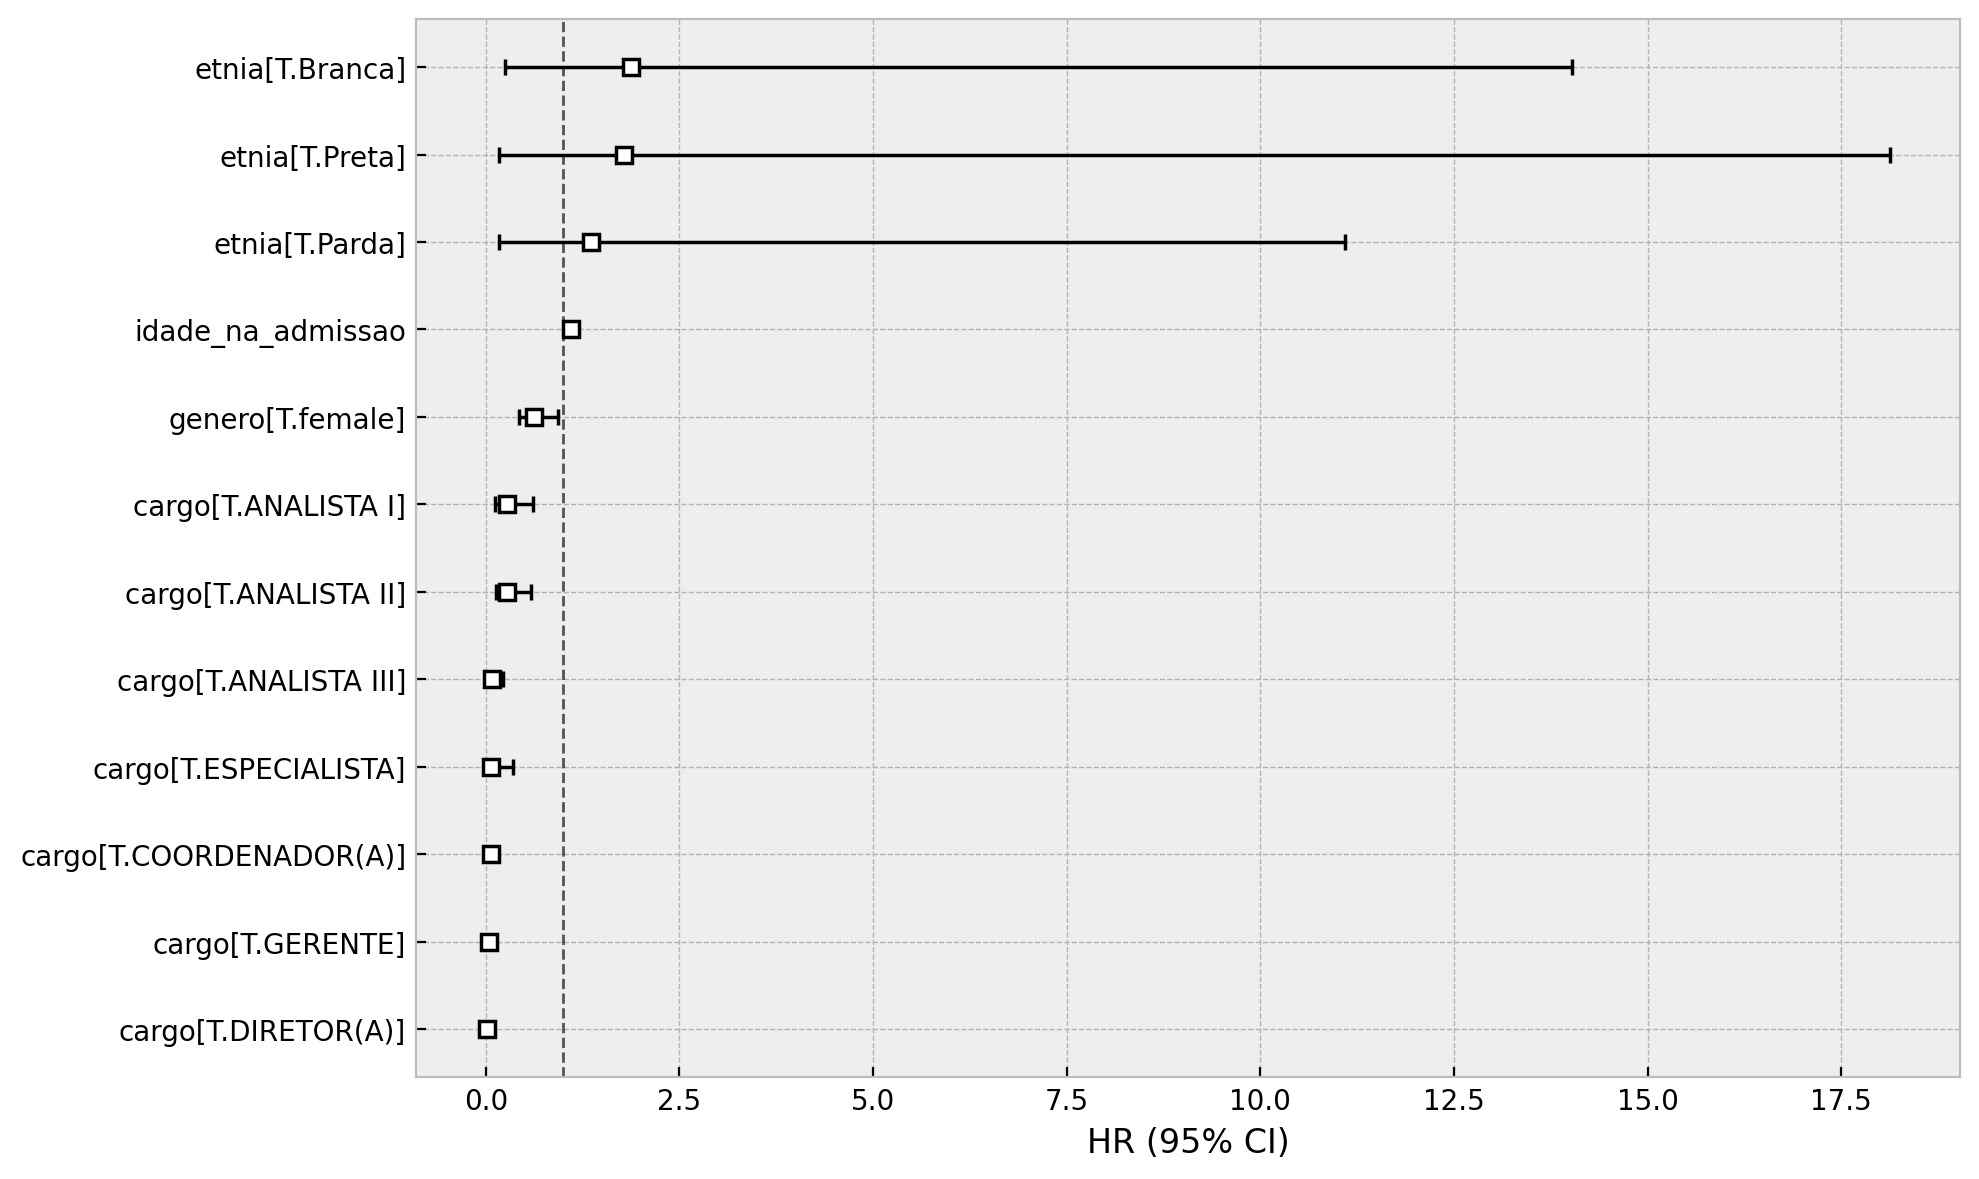

In [17]:
fig, ax = plt.subplots()
turnover_analysis.plot(ax=ax, hazard_ratios=True)

fig.savefig("HR.png")

In [18]:
def plot_survival_curve(ax=None, **surv_kwargs):
    if not ax:
        fig, ax = plt.subplots()
    turnover_analysis.plot_partial_effects_on_outcome(**surv_kwargs, plot_baseline=False, ax=ax)
    ax.set_xlabel("Meses")
    ax.set_ylabel("Tx. de Sobrevivência")
    ax.axvline(x=12, linewidth=1, color="black", linestyle="--")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    return ax

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


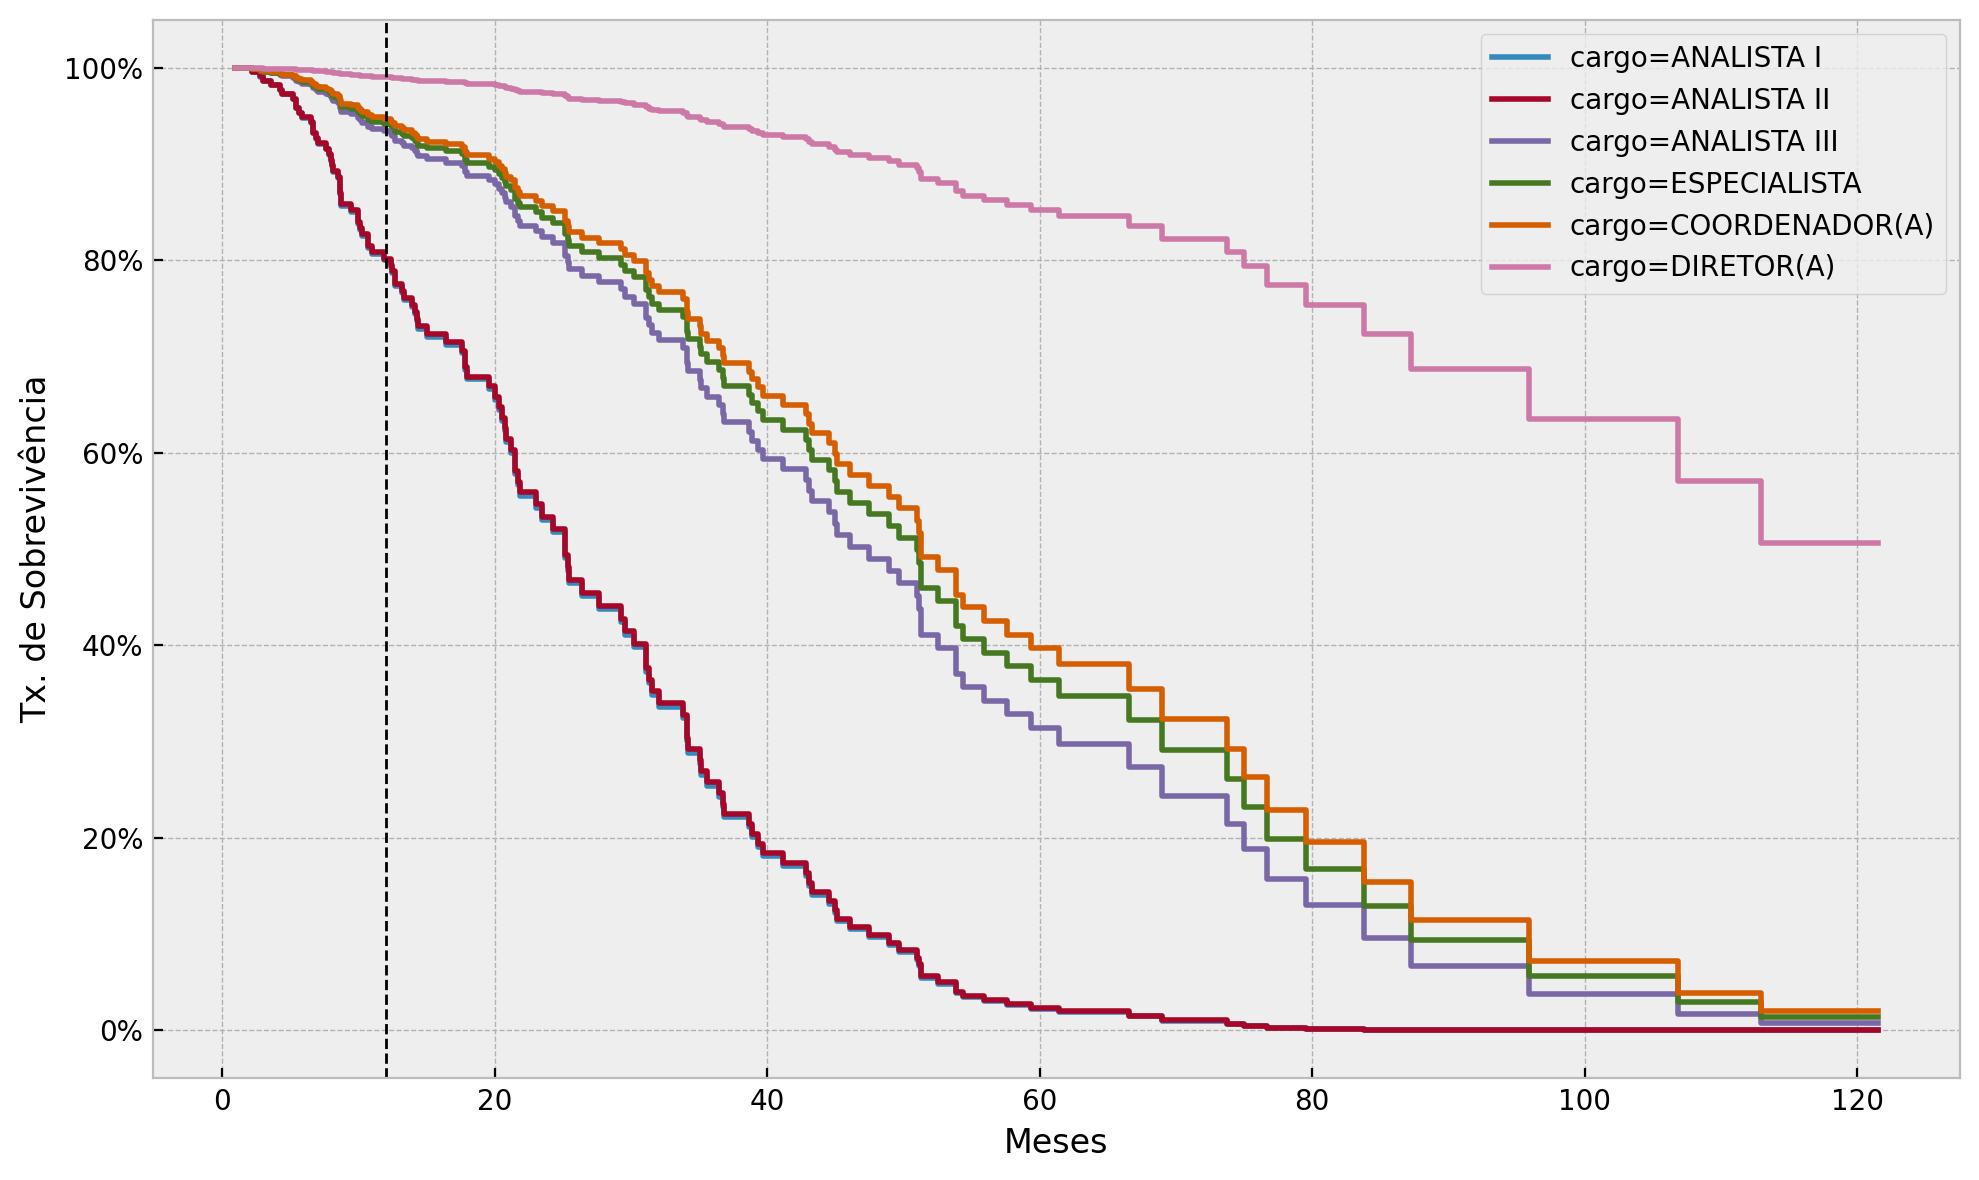

In [19]:
fig, ax = plt.subplots()

plot_survival_curve(covariates=['cargo'], values=["ANALISTA I", "ANALISTA II", "ANALISTA III", "ESPECIALISTA", "COORDENADOR(A)", "DIRETOR(A)"], ax=ax)

fig.savefig("curva_de_sobr0.png")

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


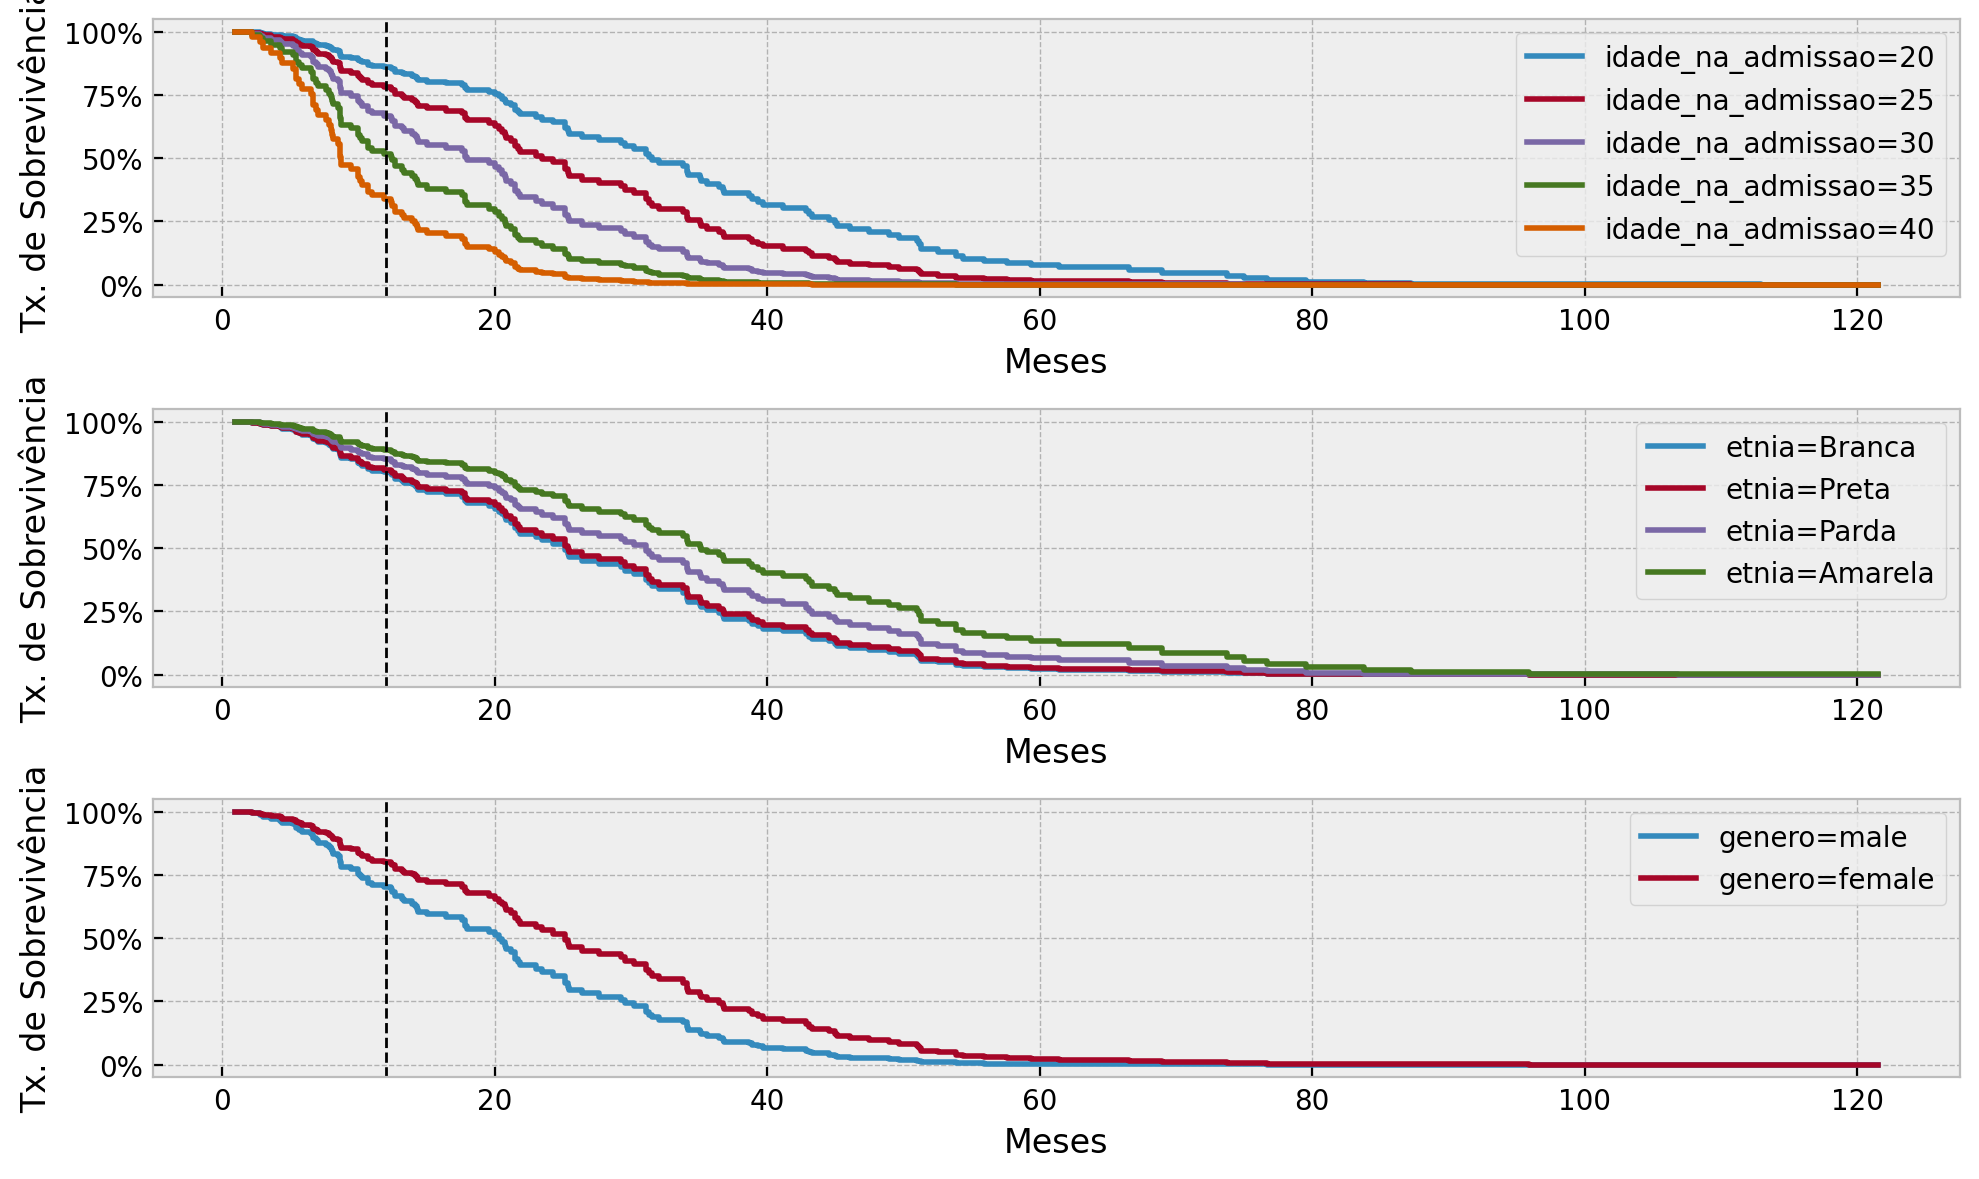

In [20]:
fig, ax = plt.subplots(nrows=3)

plot_survival_curve(covariates=['idade_na_admissao'], values=[20, 25, 30, 35, 40], ax=ax[0])
plot_survival_curve(covariates=['etnia'], values=["Branca", "Preta", "Parda", "Amarela"], ax=ax[1])
plot_survival_curve(covariates=['genero'], values=["male", "female"], ax=ax[2])

fig.savefig("curva_de_sobr1.png")

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  r

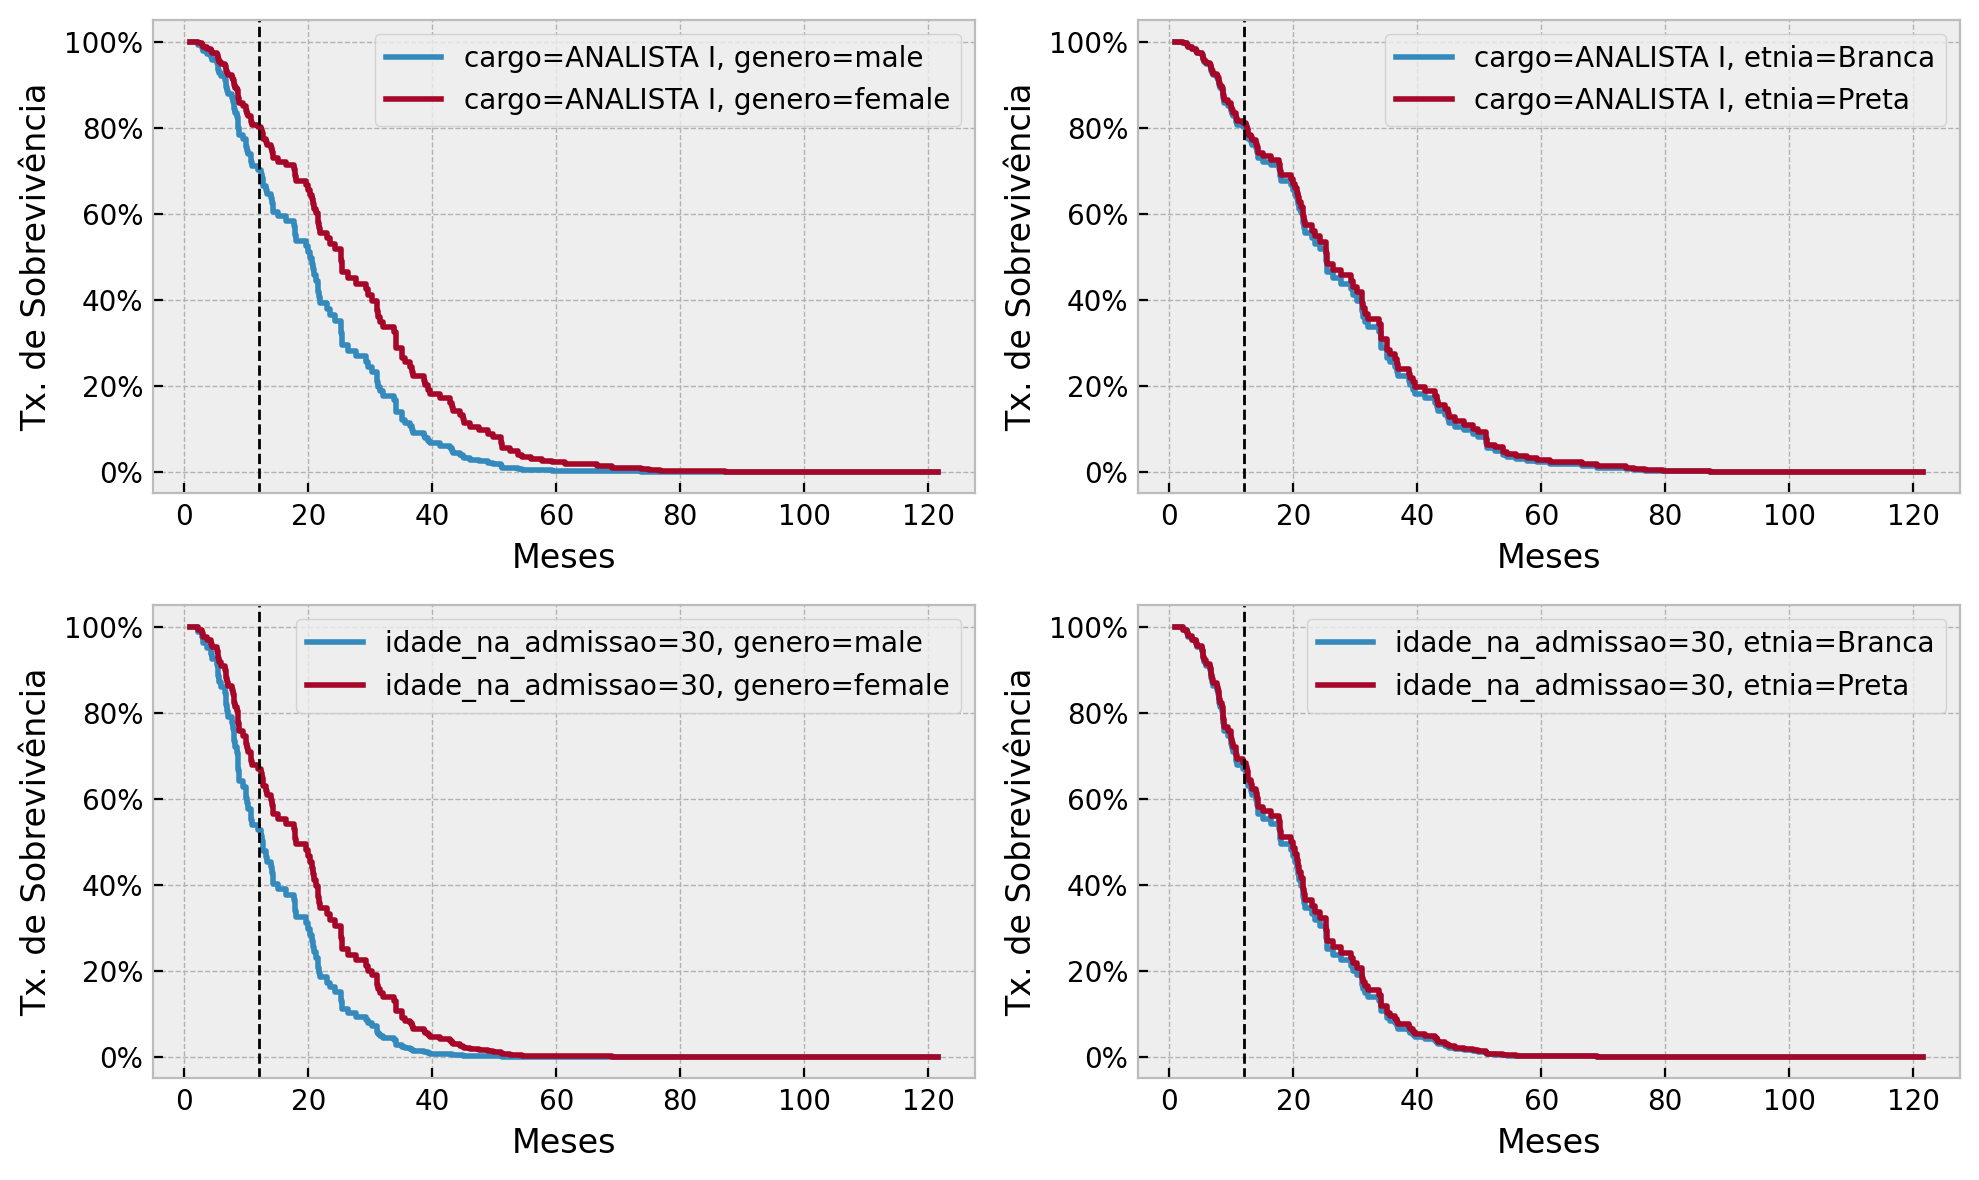

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=2)

plot_survival_curve(covariates=['cargo', "genero"], 
                    values=[["ANALISTA I", "male"], ["ANALISTA I", "female"]], ax=ax[0, 0])
plot_survival_curve(covariates=['cargo', "etnia"], 
                    values=[["ANALISTA I", "Branca"], ["ANALISTA I", "Preta"]], ax=ax[0, 1])

plot_survival_curve(covariates=['idade_na_admissao', "genero"], 
                    values=[[30, "male"], [30, "female"]], ax=ax[1, 0])
plot_survival_curve(covariates=['idade_na_admissao', "etnia"], 
                    values=[[30, "Branca"], [30, "Preta"]], ax=ax[1, 1])

fig.savefig("curva_de_sobr2.png")

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


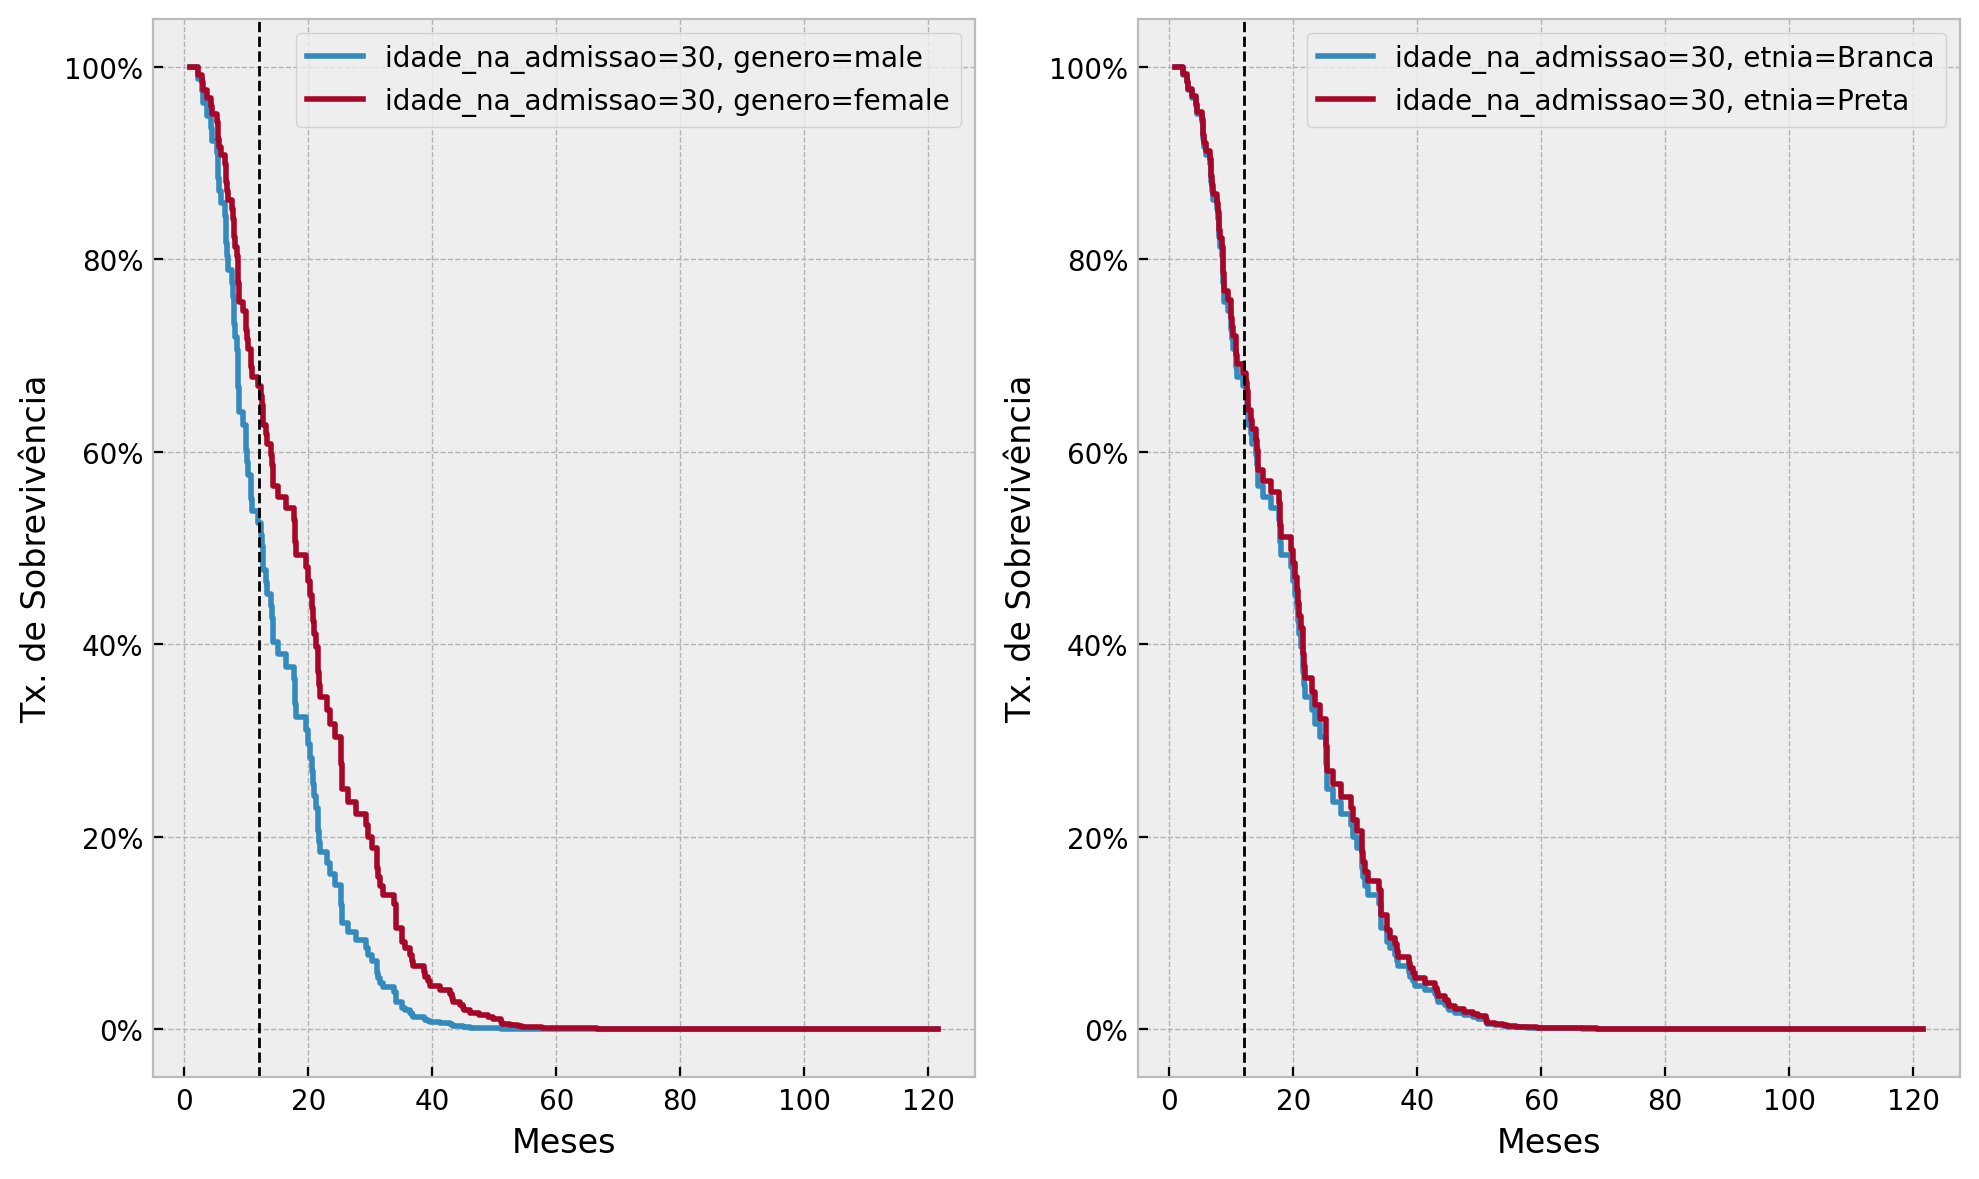

In [22]:
fig, ax = plt.subplots(ncols=2)

plot_survival_curve(covariates=['idade_na_admissao', "genero"], 
                    values=[[30, "male"], [30, "female"]], ax=ax[0])
plot_survival_curve(covariates=['idade_na_admissao', "etnia"], 
                    values=[[30, "Branca"], [30, "Preta"]], ax=ax[1])

fig.savefig("curva_de_sobr2.png")

C:\Users\silasge\miniconda3\envs\case-endeavour\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


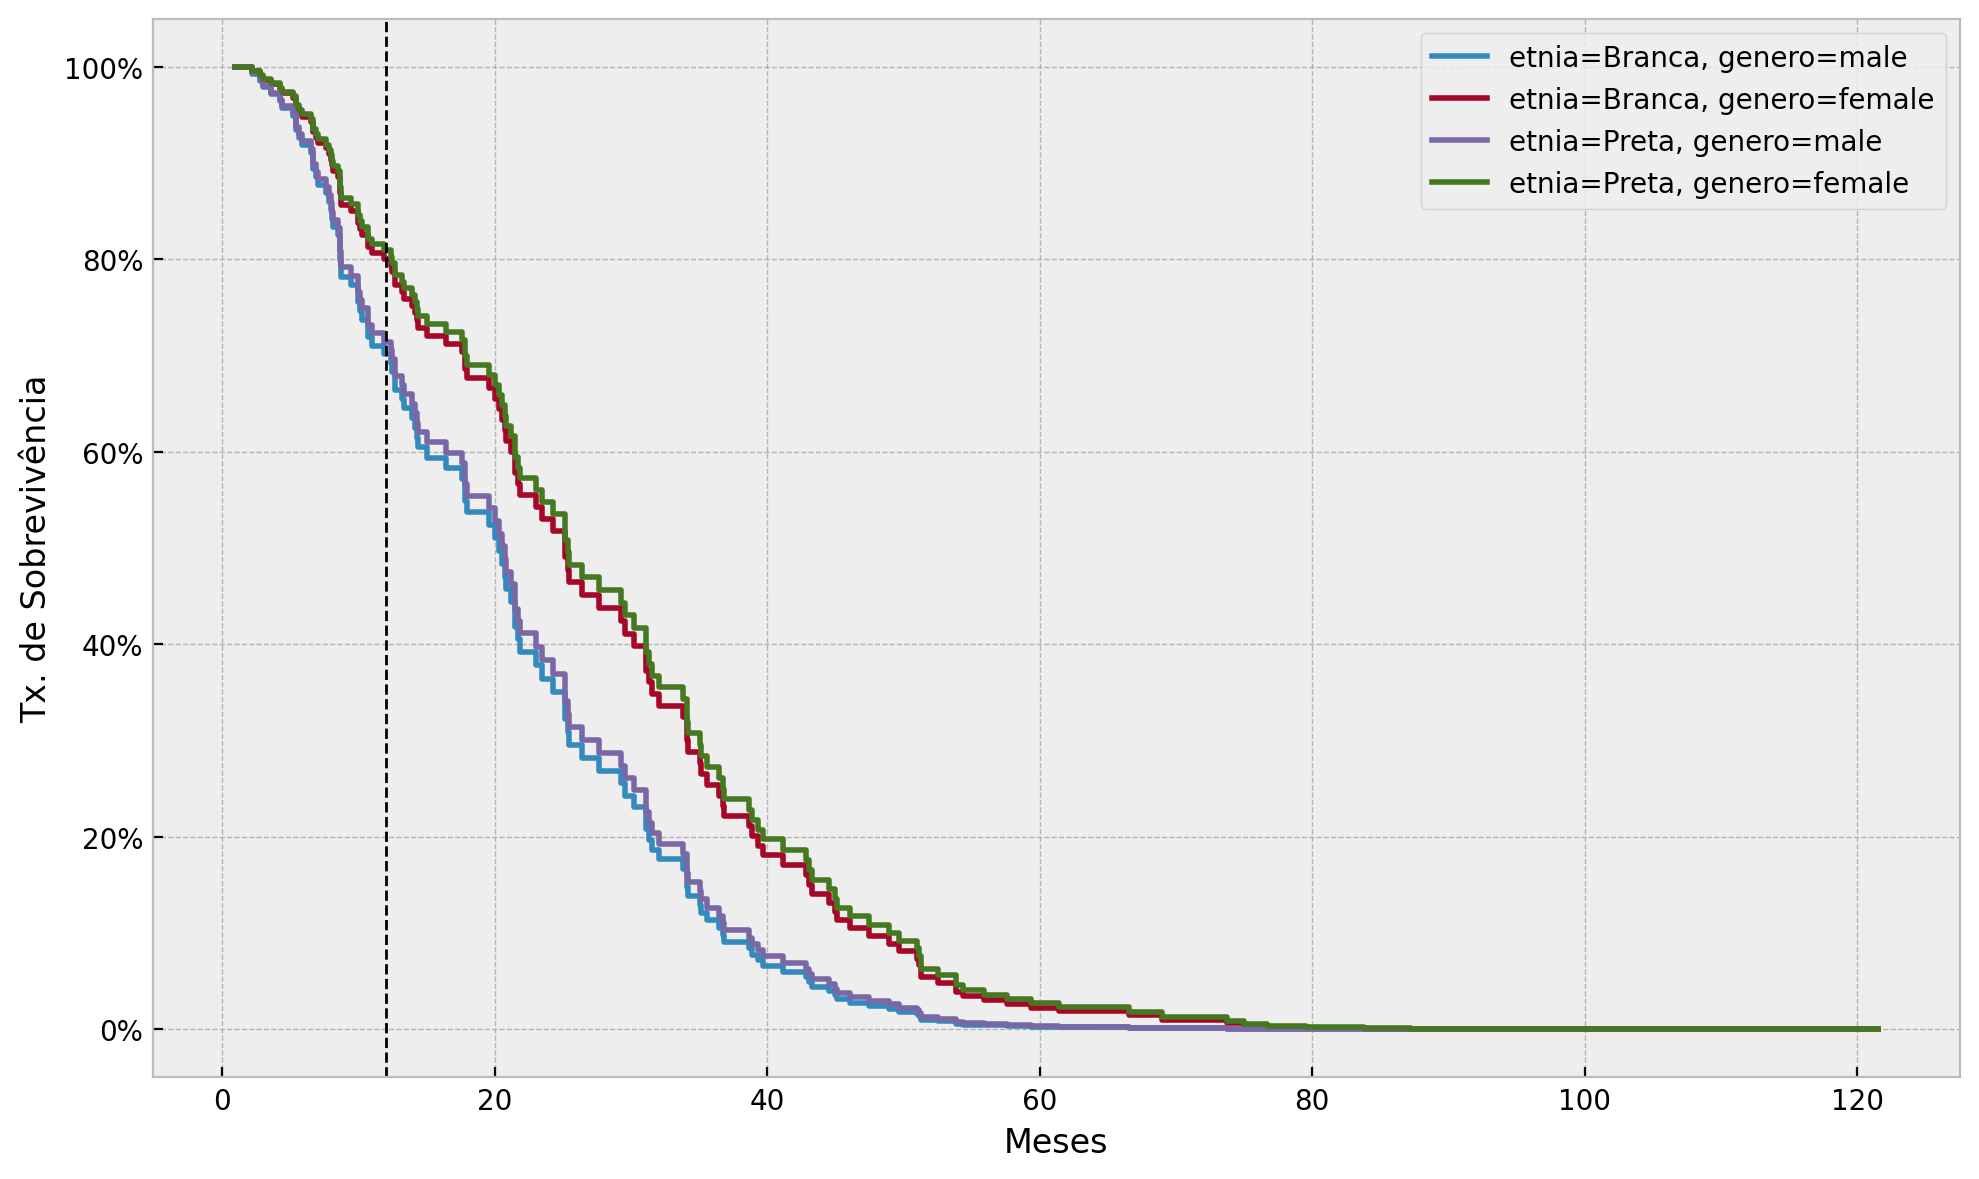

In [23]:
fig, ax = plt.subplots()

plot_survival_curve(covariates=['etnia', "genero"], 
                    values=[["Branca", "male"], 
                            ["Branca", "female"],
                            ["Preta", "male"],
                            ["Preta", "female"]], ax=ax)

fig.savefig("curva_de_sobr3.png")